In [16]:
import os
import pandas as pd
import requests
from datetime import datetime, timedelta
from binance.exceptions import BinanceAPIException
from binance.client import Client
import matplotlib.pyplot as plt

API_KEY = os.environ.get('BINANCE_API_KEY')
API_SECRET = os.environ.get('BINANCE_API_SECRET')
client = Client(API_KEY, API_SECRET)


In [17]:
try:
    response = requests.get('https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page=100&page=1&price_change_percentage=24h')
    response = response.json()
except requests.exceptions.ConnectionError:
    print('Cant connect to API')
except requests.exceptions.JSONDecodeError:
    print('Cant parse JSON response')

invalid_symbols = ['BTC','ETH','USDT','BUSD','USDC','DAI','TUSD','UST','STETH','WBTC','LUNA','BTT','CRO','LEO','NUU','KEEP']
symbols = []
for item in response:
    if item['symbol'].upper() not in invalid_symbols:
        symbols.append(f'{item["symbol"].upper()}USDT')

result = []
list_of_symbols = []
today = datetime.date(datetime.now()).strftime('%m-%d-%y')
days_ago = (datetime.today() - timedelta(days=2)).strftime('%m-%d-%y')
for s in symbols:
    try:
        # Getting historical data
        data = client.get_historical_klines(s, Client.KLINE_INTERVAL_15MINUTE, days_ago, today)
        df = pd.DataFrame(data)
        df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                        'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore'] 
        df['Open Time'] = pd.to_datetime(df['Open Time']/1000, unit='s')
        df['Close Time'] = pd.to_datetime(df['Close Time']/1000, unit='s')      
        numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
        df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, axis=1)      
        volatility = float(df[["Close"]].std()/df[["Close"]].mean()) * 100
        result.append({'symbol':s.replace('USDT',''), 'volatility':volatility})
        list_of_symbols.append(s.replace('USDT',''))
    except BinanceAPIException as e :
        # print(f'{s}: {e.message}')
        pass
    except ValueError:
        print(s)
        # pass


<AxesSubplot:xlabel='Symbol'>

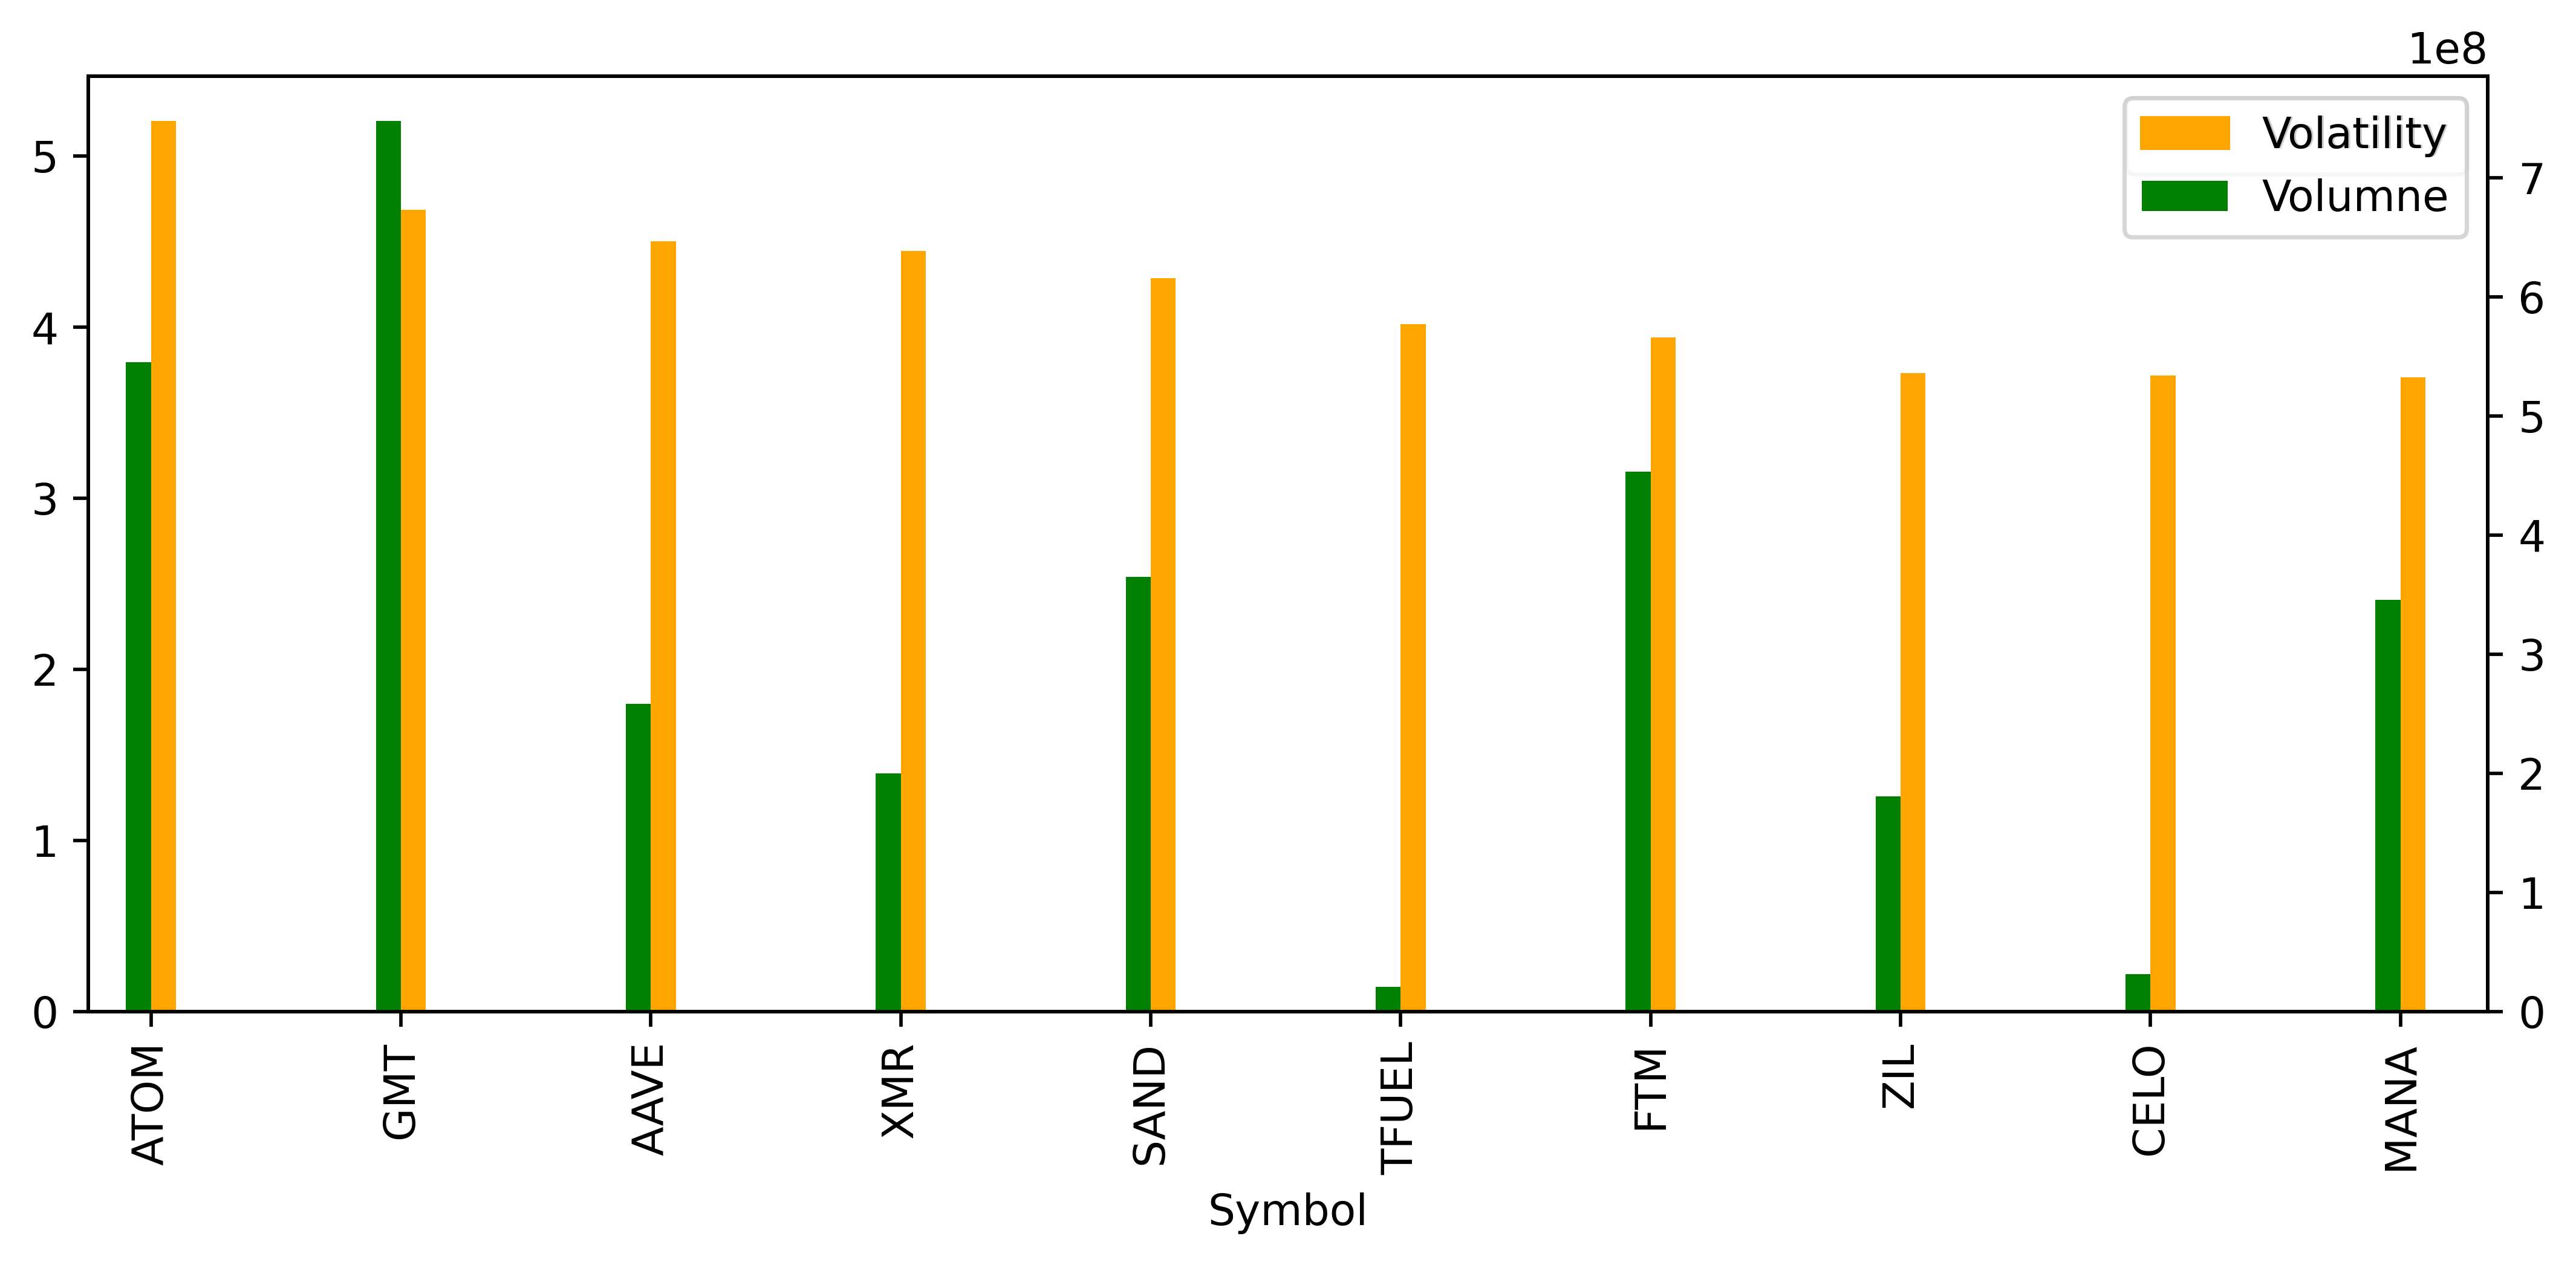

In [18]:
import matplotlib.patches as mpatches
for item in response:
    symbol = item['symbol'].upper()
    if symbol in list_of_symbols:
        idx = result.index(next(filter(lambda n: n.get('symbol') == symbol, result)))
        result[idx]['volumne'] = item['total_volume']
df2 = pd.DataFrame.from_dict(result)
df2.columns = ['Symbol', 'Volatility', 'Volumne']
df2.sort_values(by=['Volatility'], inplace=True, ascending=False)

fig = plt.figure(figsize=(10, 4), dpi=512) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
orange_patch = mpatches.Patch(color='orange', label='Volatility')
ax2.legend(handles=[orange_patch])
width = 0.1
df2.head(10).plot(x="Symbol", y=["Volumne"], kind='bar', color='green', ax=ax2, width=width, position=1)
df2.head(10).plot(x="Symbol", y=["Volatility"], kind='bar', color='orange', ax=ax, width=width, position=0)
# ax.set_ylabel('')

# df2.head(10)